In [1]:
%reset

import numpy as np
import matplotlib.pyplot as pl
import pickle as pk
import pdb
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## The code below will generate the plot for problem 1

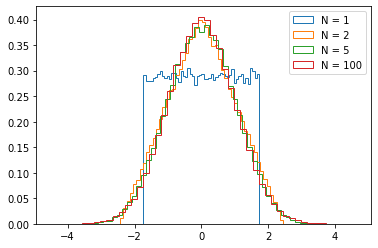

In [2]:
def generate_Y(N, num_Y):
    mu = 1/2.
    sig = np.sqrt(1/12.)
    all_X = (np.random.rand(num_Y, N) - mu)/sig
    Y = np.sum(all_X, axis = 1)
    return Y
    
N = [1,2,5,100]

fig, ax = pl.subplots(1,1)
for Ni in N:
    Y = generate_Y(Ni,100000)
    ax.hist(Y/np.sqrt(Ni), label = 'N = {}'.format(Ni), histtype = 'step', bins = 50, density = True)
ax.legend()

fig.savefig('centrallimit.png')

## The code below will generate the answers for problem 2

In [3]:
# Bootstrap function
# Here, "statistic" is a function
def bootstrap(data, statistic):
    N_data = len(data)
    N_boot = 10000 # Set this to some reasonable number
    boot_statistic_arr = np.zeros(N_boot)
    for bi in range(0,N_boot):
        #select bootstrap indices
        boot_indices = np.random.randint(0, N_data, size = N_data) 
        
        boot_sample = data[boot_indices]
        boot_statistic_arr[bi] = statistic(boot_sample)
    return boot_statistic_arr

def square(x):
    return np.mean(x**2.)

# Get the uncertainty propagation and bootstrap estimates
def get_estimators(data):
    # Estimate mu^2 and uncertainty using error propagation
    mu_est = np.mean(data)
    mu_est_std = np.std(data)/np.sqrt(len(data))
    print("sample mean and standard error = {} +/- {}".format(mu_est, mu_est_std))
    
    mu2_est = mu_est**2.
    mu2_est_std = 2.*mu_est*mu_est_std
    print("mu^2 estimate propagation = {} +/- {}".format(mu2_est, mu2_est_std))

    # Estimate mu^2 using plug-in estimator
    mu2_est = np.mean(data**2.)
    mu2_est_std = np.std(bootstrap(data, square))
    print("mu^2 plug in estimator = {} +/- {}".format(mu2_est, mu2_est_std))

In [4]:
# Generate data
mu_1 = 10.
sig_1 = 1.0
mu_2 = 1.
sig_2 = 1.0

#Generate sample
N_pts = 1000
data1 = mu_1 + np.random.randn(N_pts)
data2 = mu_2 + np.random.randn(N_pts)

# Get the values we're interested in
print("data1")
get_estimators(data1)
print("data2")
get_estimators(data2)

data1
sample mean and standard error = 9.975582766807362 +/- 0.0314761662254568
mu^2 estimate propagation = 99.51225153742402 +/- 0.6279862027276615
mu^2 plug in estimator = 100.5030005776766 +/- 0.6261032198837254
data2
sample mean and standard error = 0.9650219659625554 +/- 0.032445452835981235
mu^2 estimate propagation = 0.9312673947902355 +/- 0.06262114936464797
mu^2 plug in estimator = 1.983974804522118 +/- 0.08007824409949652


## The code below will generate the answers for problem 3

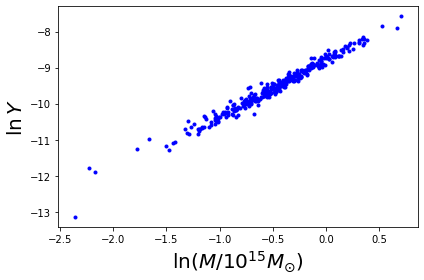

In [5]:
#Load data and plot it
data = np.genfromtxt('../../SZ_likelihood_data.dat', delimiter = ',')
lnM = np.log(data[:,0]/1.0e15)
lnY = np.log(data[:,1])

#Plot the data
fig, ax = pl.subplots(1,1)
ax.plot(lnM, lnY, 'b.')
ax.set_xlabel(r'$\ln(M/10^{15} M_{\odot})$', fontsize = 20)
ax.set_ylabel(r'$\ln Y$', fontsize = 20)
fig.tight_layout()
fig.savefig('HW_likelihood_1.png')


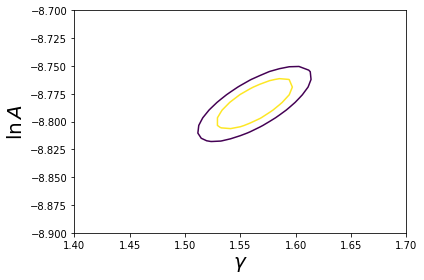

In [6]:
# Compute likelihood at fixed sigma_lnY

from scipy import stats

# Function to compute likelihood
def lnlike(params, lnM_arr, lnY_arr):
    N_data = len(lnM_arr)
    lnA = params[0]
    gamma = params[1]
    sigma_lnY = params[2]
    model = lnA + lnM_arr*gamma
    lnlike = -N_data*np.log(sigma_lnY) + np.sum(- 0.5*((lnY_arr - model)**2.)/sigma_lnY**2.)
    return lnlike

sigma_lnY_fix = 0.15

num_lnA, num_gamma = 30,35
min_lnA, max_lnA = -8.9, -8.7
min_gamma, max_gamma = 1.4, 1.7
lnA_arr = np.linspace(min_lnA, max_lnA, num = num_lnA)
gamma_arr = np.linspace(min_gamma, max_gamma, num = num_gamma)

lnlike_mat = np.zeros((num_lnA, num_gamma))
for ii in range(0,num_lnA):
    for jj in range(0,num_gamma):
        lnlike_mat[ii,jj] = lnlike([lnA_arr[ii], gamma_arr[jj], sigma_lnY_fix], lnM, lnY)

Delta = 0.5*stats.chi2.ppf([0.95, 0.68], 3)
levels = np.max(lnlike_mat) - Delta
        
fig, ax = pl.subplots(1,1)
ax.contour(gamma_arr, lnA_arr, lnlike_mat, levels = levels)
ax.set_xlabel(r'$\gamma$', fontsize = 20)
ax.set_ylabel(r'$\ln A$', fontsize = 20)
fig.tight_layout()

fig.savefig('HW_likelihood_2.png')



In [7]:
#Find the maximum likelihood parameters in 3D

from scipy.optimize import minimize

#Define a function that represents the negative log-likelihood so that we can run our minimizer
def neglnlike(params, lnM_arr, lnY_arr):
    return -1.0*lnlike(params, lnM_arr, lnY_arr)


x0 = np.array([-8.78, 1.55, 0.2])
result = minimize(neglnlike, x0, args = (lnM, lnY), bounds = ((None, None), (None, None), (0.00001, None)))

print(result)

      fun: -527.0426473827005
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.000216  ,  0.00070486, -0.00123919])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 68
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([-8.78403703,  1.56276992,  0.11863411])


In [8]:
# chi2 test

bestfit_model = result['x'][0] + result['x'][1]*lnM
chi2 = np.sum(((lnY - bestfit_model)**2.)/result['x'][2]**2.)

print("chi2 = ", chi2)
print("dof = ", len(lnY) - 3)  #since 3 free parameters
print("chi2/dof = ", chi2/len(bestfit_model))

chi2 =  323.0001724379206
dof =  320
chi2/dof =  1.0000005338635312


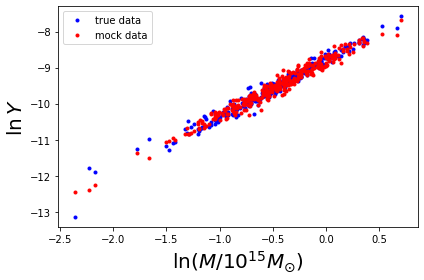

In [9]:
# Mock data goodness of fit test

lnY_mock = result['x'][0] + result['x'][1]*lnM + np.random.randn(len(lnM))*result['x'][2]
fig, ax = pl.subplots(1,1)
ax.plot(lnM, lnY, 'b.', label = 'true data')
ax.plot(lnM, lnY_mock, 'r.', label = 'mock data')
ax.set_xlabel(r'$\ln(M/10^{15} M_{\odot})$', fontsize = 20)
ax.set_ylabel(r'$\ln Y$', fontsize = 20)
ax.legend()
fig.tight_layout()
fig.savefig('HW_likelihood_3.png')


gamma = 1.5627699211262736 +/- 0.010003284028230957


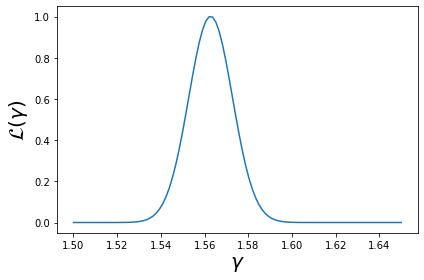

In [10]:
# Errorbars on gamma

#Plot gamma
fig, ax = pl.subplots(1,1)
gamma_plot = np.linspace(1.5, 1.65, num = 100)
like_plot = np.zeros(len(gamma_plot))
for ii in range(0,len(gamma_plot)):
    like_plot[ii] = lnlike([result['x'][0], gamma_plot[ii], result['x'][2]], lnM, lnY)
ax.plot(gamma_plot, np.exp(like_plot- np.max(like_plot)))
ax.set_xlabel(r'$\gamma$', fontsize = 20)
ax.set_ylabel(r'$\mathcal{L}(\gamma)$', fontsize = 20)
fig.tight_layout()
fig.savefig('HW_likelihood_4.png')


# Determine errorbar using Fisher matrix
gamma_MLE = result['x'][1]

#use finite difference method to get second derivative of log-likelihood at MLE
h = 0.01
f_x = lnlike([result['x'][0], gamma_MLE, result['x'][2]], lnM, lnY)
f_x_plus_h = lnlike([result['x'][0], gamma_MLE + h, result['x'][2]], lnM, lnY)
f_x_minus_h = lnlike([result['x'][0], gamma_MLE - h, result['x'][2]], lnM, lnY)
second_deriv = (f_x_plus_h - 2.*f_x + f_x_minus_h)/(h**2.)
sigma_gamma = (-second_deriv)**(-1./2.)

print("gamma = {} +/- {}".format(gamma_MLE, sigma_gamma))


## The code below will generate the answers for problem 4

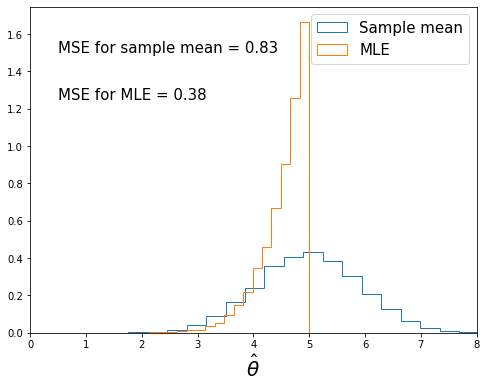

In [11]:
# Uniform sample problem
theta = 5
N_samples = 10
N_trials = 10000

samplemean_arr = np.zeros(N_trials) #stores the sample mean
mle_arr = np.zeros(N_trials) #stores the MLE

#Run trials
for ii in range(N_trials):
    #draw random data from uniform distribution
    dd = np.random.rand(N_samples)*(theta*2.)
    
    #compute sample mean
    samplemean_arr[ii] = np.mean(dd)
    
    #compute MLE
    mle_arr[ii] = np.max(dd)/2.

#Compute mean squared error
MSE_samplemean = np.mean((samplemean_arr - theta)**2.)
MSE_MLE = np.mean((mle_arr - theta)**2.)
    
fig, ax = pl.subplots(1,1, figsize = (8,6))
ax.hist(samplemean_arr, label = 'Sample mean', density = True, histtype = 'step', bins = 20)
ax.hist(mle_arr, label = 'MLE', density = True, histtype = 'step', bins = 20)
ax.set_xlabel(r'$\hat{\theta}$', fontsize = 20)
ax.legend(fontsize = 15)
ax.text(0.5, 1.5,"MSE for sample mean = {:.2f}".format(MSE_samplemean), fontsize = 15)
ax.text(0.5, 1.25,"MSE for MLE = {:.2f}".format(MSE_MLE), fontsize = 15)
ax.set_xlim((0, 8))

fig.savefig('MLE_uniform.png')